In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
pip install mpi4py

     |████████████████████████████████| 2.5 MB 32.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185300 sha256=09b9ca0ad79007052114dacbc67c807913e9fa5b18693aeed41055356ac1c9a7
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py


In [ ]:
%%writefile spectrogram.py
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt

def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()




    window_width=2.0*2*np.pi
    t = np.linspace(-20 * 2 * np.pi, 20 * 2 * np.pi, 2**14)
    y=np.sin(2 * t)*np.exp(-t**2/2/20**2)
    y=y+np.sin(3*t)*np.exp(-(t-2*2*np.pi)**2/2/20**2)
    y=y+np.sin(5*t)*np.exp(-(t+4*2*np.pi)**2/2/5**2) 

    w = np.fft.fftfreq(len(t), d=(t[1] - t[0]) / 2 / np.pi)
    w_mask = (w >= 0) * (w <= 20)
    # print(len(w_mask == True))
    nwindowsteps = 2 *3 * 4 * 5 * 6 * 7 * 8
    window_positions = np.array_split(np.linspace(t.min(), t.max(), nwindowsteps), size)[rank]  

    specgram = []
    recvbuf_specgram = None   
    if rank == 0:
        recvbuf_specgram = np.empty((nwindowsteps, sum(w_mask)), dtype='d')
        # print(f'rank is {rank} recvbuf_specgram shape is {recvbuf_specgram.shape}')

    start = MPI.Wtime()
    
    for window_position in window_positions:
        
        window_function=np.exp(-(t-window_position)**2/2/window_width**2)
        y_window = y * window_function

        sp = np.abs(np.fft.fft(y_window)) ** 2

#         mask = (w >= 0) * (w <= 10)
#         w = w[mask]
        sp = sp[w_mask]
        
        specgram.append(sp)
    specgram = np.array(specgram, dtype='d')

    # print(f'rank is {rank} specgram shape is {specgram.shape}')
    comm.Gather(np.array(specgram), recvbuf_specgram, root = 0)
    end = MPI.Wtime()

    if rank == 0:
        print(f'Size is {size} time is {end - start}')
        plt.figure(figsize = (20, 12))
        aspect = ((max(t) - min(t)) / 2 / np.pi) / (max(w) - min(w))
        extent = [min(t) / 2 / np.pi, max(t) / 2 / np.pi, min(w), max(w)]
        plt.imshow(recvbuf_specgram.T, aspect=aspect, origin='lower', extent=extent)
        plt.xlabel('t, cycles', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.title(' Spectrogram', fontsize=14)
        plt.savefig('Spectrogram.png')
    
main()

Overwriting spectrogram.py


In [ ]:
! mpirun --allow-run-as-root -np 1 python spectrogram.py
! mpirun --allow-run-as-root -np 2 python spectrogram.py
! mpirun --allow-run-as-root -np 3 python spectrogram.py
! mpirun --allow-run-as-root -np 4 python spectrogram.py
! mpirun --allow-run-as-root -np 5 python spectrogram.py
! mpirun --allow-run-as-root -np 6 python spectrogram.py
! mpirun --allow-run-as-root -np 7 python spectrogram.py
! mpirun --allow-run-as-root -np 8 python spectrogram.py


Size is 1 time is 37.907984096000064
Size is 2 time is 33.00536110799999
Size is 3 time is 34.30479751600001
Size is 4 time is 35.27034836199982
Size is 5 time is 35.84986616099991
Size is 6 time is 42.17251530700014
Size is 7 time is 37.14214813700005
Size is 8 time is 36.78232160100015


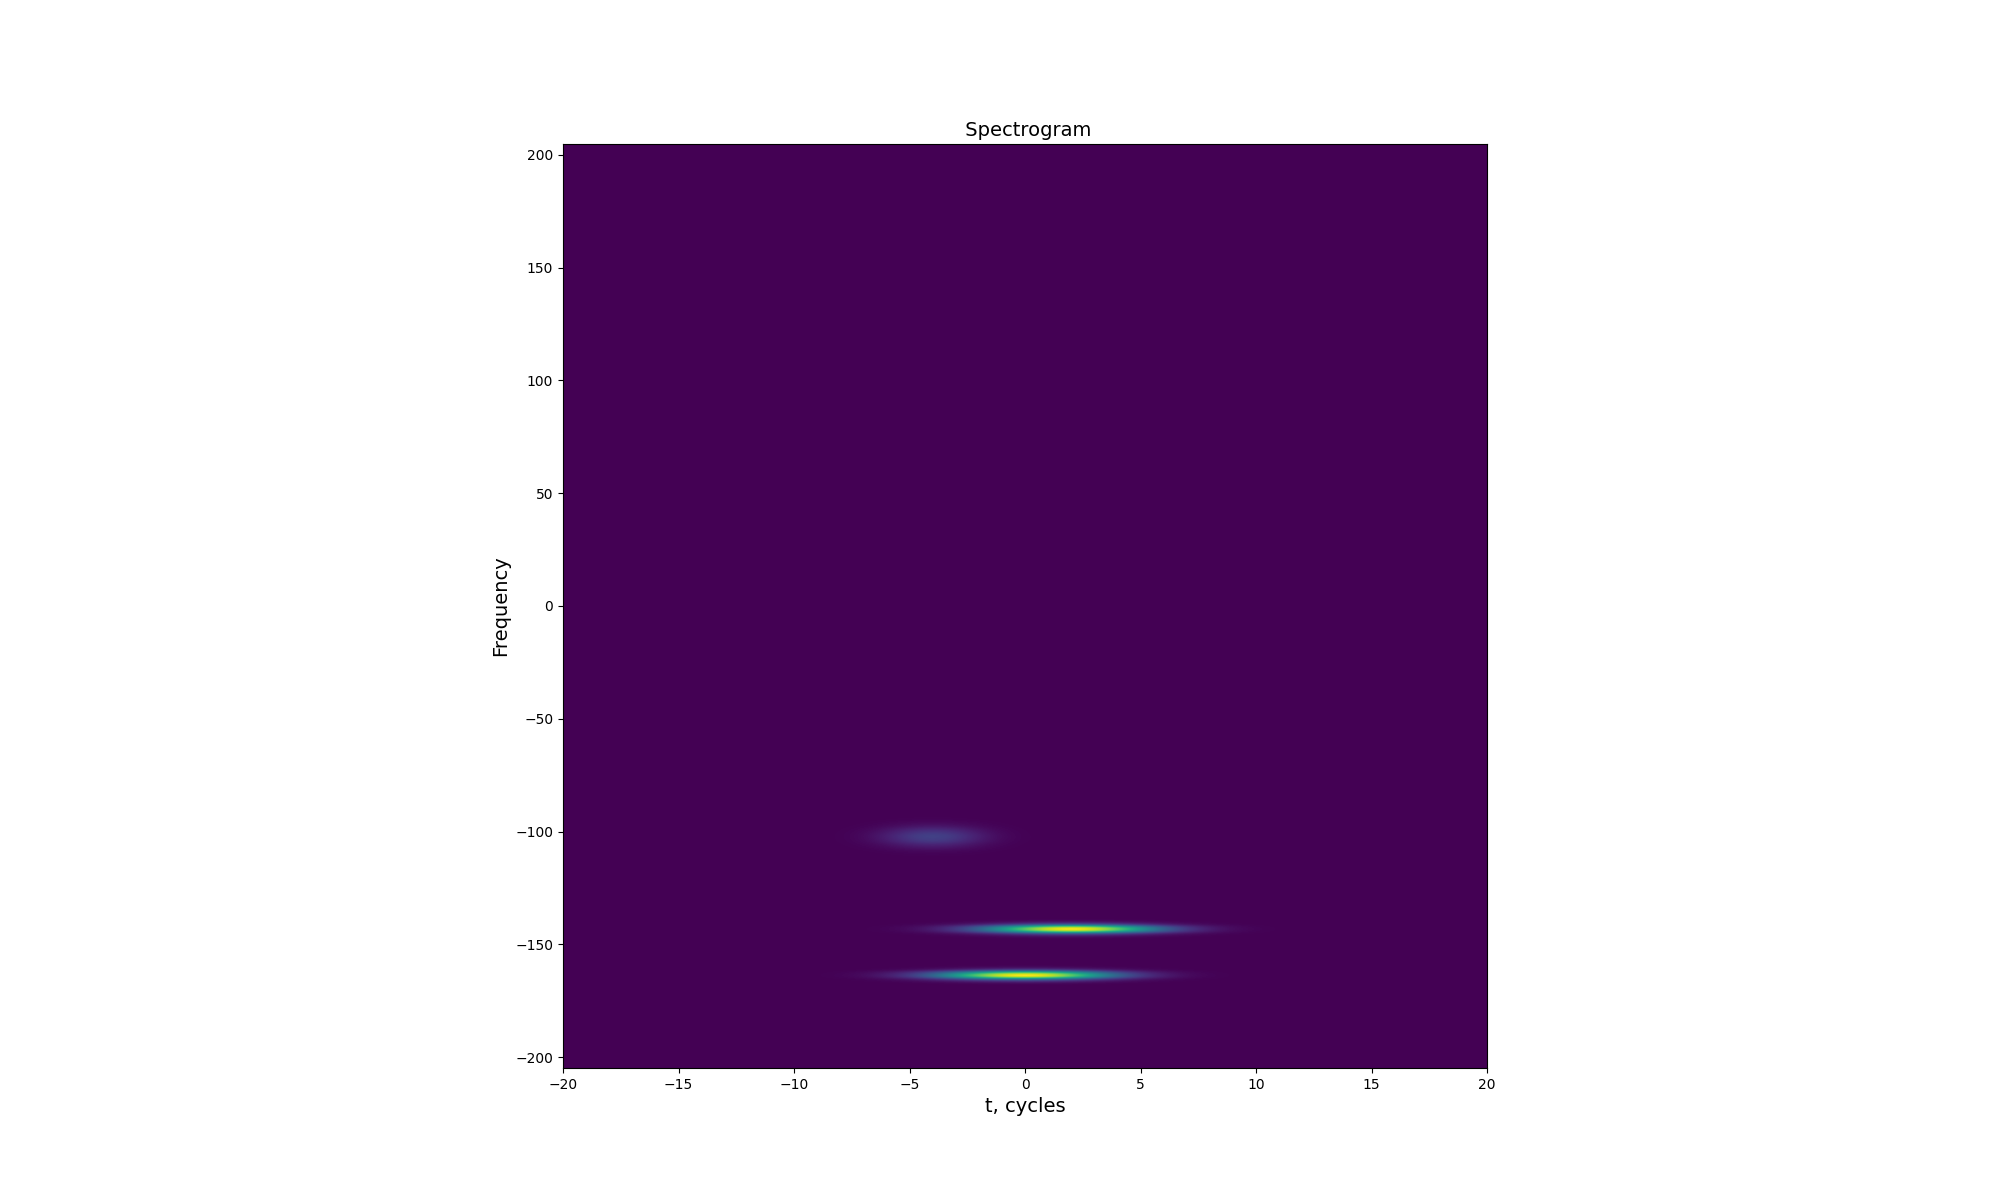

In [ ]:
from PIL import Image
Image.open('Spectrogram.png')

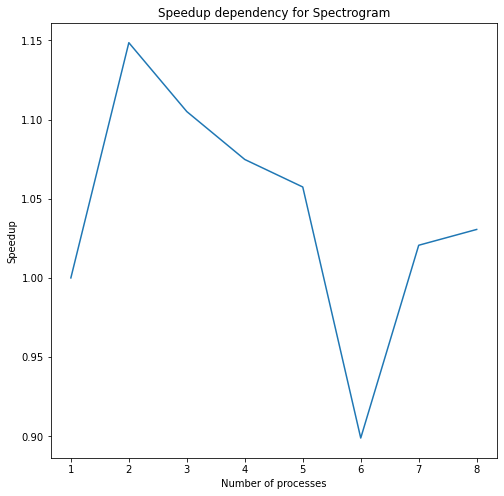

In [ ]:
times = [37.907984096000064,
33.00536110799999,
34.30479751600001,
35.27034836199982,
35.84986616099991,
42.17251530700014,
37.14214813700005,
36.78232160100015]

plt.figure(figsize = (8, 8))
plt.plot([i for i in range(1, len(times)+1)], [ times[0] / time for time in times])
plt.xlabel('Number of processes')
plt.ylabel('Speedup')
plt.title('Speedup dependency for Spectrogram')
plt.show()